<a href="https://colab.research.google.com/github/skywalker0803r/Job-OEM/blob/main/movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 創建基於用戶-用戶鄰域的協同過濾推薦系統

簡介 在本筆記本中，我們將使用 Movielens 100K 數據集構建推薦系統。

協同過濾是一種依賴於用戶的偏好來提出建議的方法。

推薦系統將使用基於內存的算法，這意味著將對整個數據集進行統計計算，以預測用戶的偏好。

將遵循基於用戶的方法，這意味著將計算用戶之間的相似性。 最後，Neighborhood-Based 方法的選擇將是 K-NearestNeighbors：來自最近鄰居列表的評級將被組合以預測未知評級

In [63]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import warnings

獲取數據 從 u.data 文件中讀取每部電影的用戶評分，並從 u.item 文件中獲取電影名稱

In [65]:
udata_path = '/content/u.data'
user_ratings = pd.read_csv(udata_path,sep='\t',names=['user_id','movie_id','rating'],usecols=[0,1,2])
uitem_path = '/content/u.item'
movie_info =  pd.read_csv(uitem_path, sep='|', names=['movie_id','title'],usecols=[0,1],encoding="ISO-8859-1")

將信息合併到一個 DataFrame 中

In [66]:
user_ratings = pd.merge(movie_info, user_ratings)

user_ratings.head()

,movie_id,title,user_id,rating
0,1,Toy Story (1995),308,4
1,1,Toy Story (1995),287,5
2,1,Toy Story (1995),148,4
3,1,Toy Story (1995),280,4
4,1,Toy Story (1995),66,3


創建用戶-項目評分矩陣。每行是一個用戶，值是用戶對每部電影的評分。電影標題在列中找到

In [67]:
user_ratings = user_ratings.pivot_table(index=['user_id'],columns=['title'],values='rating')
user_ratings.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


我們創建了一個函數，該函數返回dataframe具有的非 Nan 值的百分比。

In [68]:
def df_fill_percentage(data):
    return round( data.notna().sum().sum() / (data.shape[0] * data.shape[1]) * 100, 2)
df_fill_percentage(user_ratings)

6.35

每個用戶的評分數

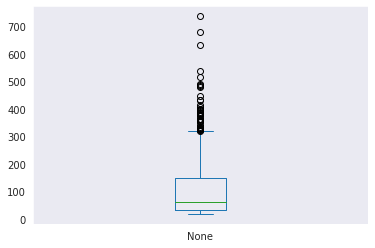

In [69]:
user_ratings.count(axis=1).plot(kind='box')

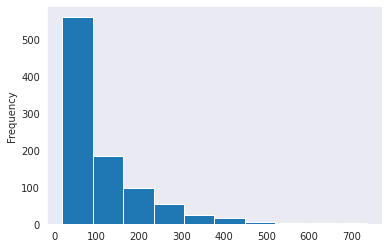

In [70]:
user_ratings.count(axis=1).plot(kind='hist')

User - 用戶協同過濾

通過找到一些用戶這些用戶是
與我們要推薦給的用戶有相似偏好的人
來做推薦系統

這可以分為 3 個步驟：

相似度矩陣的計算

找到每個用戶的 K 個最近的鄰居

結合鄰里的評級來預測評級

1. 相似度計算——使用皮爾遜相關係數

In [71]:
user_distances = user_ratings.transpose().corr(method='pearson')

稍後我們將使用 user_distances 為每個用戶找到 K 個最近的鄰居。 這意味著我們必須確保每個用戶至少擁有該數量 (K) 的鄰居。少於 K 個鄰居的用戶將被排除在推薦之外。

In [74]:
nneighbors = 10
# Keep only the rows+columns with at least nneighbors+1 number non-NA values.
user_distances = user_distances.dropna(axis=0, thresh=nneighbors+1).dropna(axis=1,thresh=nneighbors+1)
# Make the matrix square (dropping the extra rows as well)
user_distances = user_distances.loc[user_distances.columns]

我們不需要計算相關性，而是計算用戶之間的距離。為此，我們將使用 Pearson 的距離度量

In [75]:
# from PCC ranging [-1,+1] to Pearson's distance [0,2]
user_distances = 1.0 - user_distances
# solves floating point precision problem
user_distances[user_distances < 0] = 0

2.鄰里的形成 使用來自 sklearn.neighbors 的 NearestNeighbors 找到每個用戶的 K 個最近鄰居。我們在上一步中為我們的數據預先計算了一個距離矩陣。

In [77]:
# metric is “precomputed”, 
# X is assumed to be a distance matrix and must be square during fit
model_knn = NearestNeighbors(metric='precomputed', 
                             algorithm='brute', n_neighbors=10, n_jobs=-1)
# fit
# X may be a sparse graph, in which case only “nonzero” elements may be considered neighbors
model_knn.fit(csr_matrix(user_distances.fillna(0).values))
# predict
similarity, indexes = model_knn.kneighbors(csr_matrix(user_distances.fillna(0).values), 
                                           n_neighbors=nneighbors)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


In [78]:
neighborhoods = pd.DataFrame({'neighborhood_ids':[user_distances.iloc[neighbors].index.to_list() 
                                                for neighbors in indexes], 
                              'distance': similarity.tolist()}, 
                             index=user_distances.index)
neighborhoods

,neighborhood_ids,distance
user_id,,
1,"[520, 107, 687, 34, 105, 740, 485, 400, 873, 510]","[0.08144134645630818, 0.08346578621692213, 0.0..."
2,"[426, 341, 476, 267, 310, 766, 352, 162, 338, ...","[1.1102230246251565e-16, 0.015268072165338209,..."
3,"[618, 879, 368, 563, 359, 906, 867, 512, 452, ...","[2.220446049250313e-16, 2.220446049250313e-16,..."
4,"[825, 899, 739, 169, 812, 168, 325, 80, 369, 711]","[2.220446049250313e-16, 0.015268072165338209, ..."
5,"[728, 791, 482, 565, 797, 415, 781, 931, 571, ...","[0.018019493938034148, 0.029274656605848937, 0..."
...,...,...
939,"[482, 578, 640, 728, 832, 609, 397, 451, 492, ...","[1.1102230246251565e-16, 1.1102230246251565e-1..."
940,"[726, 859, 300, 105, 289, 4, 510, 428, 353, 872]","[0.018019493938034148, 0.01801949393803437, 0...."
941,"[801, 243, 350, 781, 841, 451, 610, 93, 431, 574]","[1.1102230246251565e-16, 2.220446049250313e-16..."


3. 結合最近鄰列表中的評分來預測未知評分

對於每個用戶，我們將使用他們各自的鄰域 (K-NearestNeighbors) 來計算評分。 讓我們先為 id 為 1 的用戶計算，
然後創建一個適用於所有用戶的通用函數

In [79]:
neighbors = neighborhoods['neighborhood_ids'].loc[1]
neighbors

[520, 107, 687, 34, 105, 740, 485, 400, 873, 510]

最後，我們可以為 id 為 1 的用戶計算其鄰居對電影的評分預測。

這個計算可以使用各種函數，最常用的是使用相似性的鄰居評級的加權平均值，但我們現在將使用簡單的平均值。

In [80]:
user_ratings.loc[neighbors].mean()

title
'Til There Was You (1997)                NaN
1-900 (1994)                             NaN
101 Dalmatians (1996)                    NaN
12 Angry Men (1957)                      NaN
187 (1997)                               2.5
                                        ... 
Young Guns II (1990)                     NaN
Young Poisoner's Handbook, The (1995)    NaN
Zeus and Roxanne (1997)                  NaN
unknown                                  NaN
Á köldum klaka (Cold Fever) (1994)       NaN
Length: 1664, dtype: float64

# Putting it all together

In [82]:
def usercf_predict_rating_closure(user_ratings, neighborhoods):
    # 創建預測評分的函數
    def usercf_predict_rating_using_nmean(row):
        # 對於行的用戶
        # 根據鄰居用戶的平均評分計算評分
        # 對結果進行四捨五入（因為評分是整數值）
        # 獲取該行用戶的鄰居id
        neighbors_ids = neighborhoods['neighborhood_ids'].loc[row.name]
        # 計算預測結果
        pred_ratings = user_ratings.loc[neighbors_ids].mean()
        return round(pred_ratings)
    
    return usercf_predict_rating_using_nmean

In [84]:
def recommendation_system_user_model(minperiods, nneighbors, user_ratings):
    # user_distances = user similarity matrix. 
    user_distances = user_ratings.transpose().corr(method='pearson',min_periods=minperiods)
    # Keep only the rows+columns with at least nneighbors+1 number non-NA values.
    user_distances = user_distances.dropna(axis=0,thresh=nneighbors+1).dropna(axis=1,thresh=nneighbors+1)
    # Make the matrix square (dropping the extra rows as well)
    user_distances = user_distances.loc[user_distances.columns]
    # from PCC ranging [-1,+1] to Pearson's distance [0,2]
    user_distances = 1 - user_distances
    # replace negative values with zero (solving float precision issue)
    user_distances[user_distances < 0] = 0
    # define model
    # metric is “precomputed”, 
    # X is assumed to be a distance matrix and must be square during fit
    model_knn = NearestNeighbors(metric='precomputed', algorithm='brute',n_neighbors=nneighbors, n_jobs=-1)
    # fit
    # X may be a sparse graph, 
    # in which case only “nonzero” elements may be considered neighbors
    model_knn.fit(csr_matrix(user_distances.fillna(0).values))
    # predict
    similarity, indexes = model_knn.kneighbors(csr_matrix(user_distances.fillna(0).values),n_neighbors=nneighbors)
    # dataframe with list of nns per user and their distances
    neighborhoods = pd.DataFrame({'neighborhood_ids':[user_distances.iloc[neighbors].index.to_list() for neighbors in indexes], 
                                  'distance': similarity.tolist()}, 
                                 index=user_distances.index)
    # Combine ratings using mean 
    pred = user_ratings.reindex(neighborhoods.index).apply(usercf_predict_rating_closure(user_ratings,neighborhoods),axis='columns')
    # Merge known ratings with predicted ratings for the final result
    user_ratings.merge(pred, how='right')
    return pred, neighborhoods

# 測試與評估

構建推薦系統的一個巨大挑戰是找到衡量其預測質量的方法。 根據 Herlocker 等人的說法。

在評估協同過濾推薦系統中，我們可以為其定義一些指標，例如覆蓋率和準確性。

覆蓋率：衡量推薦系統可以提供預測的項目的百分比。

準確度：衡量預測準確度的指標 對於覆蓋率，我們將檢查用戶的百分比和系統無法生成任何預測的電影的百分比。

我們將使用平均絕對誤差 (MAE) 作為預測精度指標，這是最常用於評估協同過濾的指標之一

In [85]:
# because of NaNs, custom MAE calculation function is created
def mae(user_ratings, predicted_ratings):
    # absolute difference of actual and predicted rating
    abs_dif = abs(user_ratings - predicted_ratings)
    # number of non-nan values
    n = np.sum(user_ratings.count()) 
    return abs_dif.sum().sum()/ n

# 獲取測試和訓練數據

In [88]:
# Read user ratings for each movie from the `u.data` file 
# and get the names of the movies from the `u.item` file
ua_train_path = '/content/drive/MyDrive/作業代工/movielens/input/ua.base'
ua_test_path = '/content/drive/MyDrive/作業代工/movielens/input/ua.test'
movie_info_path = '/content/drive/MyDrive/作業代工/movielens/input/u.item'
user_ratings_train = pd.read_csv(ua_train_path,sep='\t',names=['user_id','movie_id','rating'], usecols=[0,1,2])
user_ratings_test = pd.read_csv(ua_test_pat,sep='\t',names=['user_id','movie_id','rating'], usecols=[0,1,2])
movie_info =  pd.read_csv(movie_info_path, sep='|', names=['movie_id','title'],usecols=[0,1],encoding="ISO-8859-1")

# Merge the information in one DataFrame
user_ratings_train = pd.merge(movie_info, user_ratings_train)
user_ratings_test = pd.merge(movie_info, user_ratings_test)

# Create the user-item rating matrix. 
# Each row is a user, and the values are the user's ratings for each movie. 
# The movie titles are found in the columns
user_ratings_train = user_ratings_train.pivot_table(index=['user_id'],
                                        columns=['title'],
                                        values='rating')

user_ratings_test = user_ratings_test.pivot_table(index=['user_id'],
                                        columns=['title'],
                                        values='rating')

print(user_ratings_train.shape)
print(user_ratings_test.shape)

(943, 1662)
(943, 1119)


Because of the memory based approach, the input of the system needs to include all the movies and users available. This is why we must reindex the train and test data to include the whole dataset

In [89]:
user_ratings_train = user_ratings_train.reindex(
                            index=user_ratings_train.index.union(user_ratings_test.index), 
                            columns=user_ratings_train.columns.union(user_ratings_test.columns) )

user_ratings_test = user_ratings_test.reindex(
                            index=user_ratings_train.index.union(user_ratings_test.index), 
                            columns=user_ratings_train.columns.union(user_ratings_test.columns) )

print(user_ratings_train.shape)
print(user_ratings_test.shape)

(943, 1664)
(943, 1664)


# 超參數調整

調整 min_periods n_neighbors


In [92]:
scoreboard = []
for min_periods in [3, 5, 10]:
    for n_neighbors in [3 ,5, 10]:
        # temporarily supress warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pred, neighborhoods = recommendation_system_user_model(min_periods,n_neighbors,user_ratings_train)
        # reindex predictions to include all users 
        # (some get filtered for not having enough neighbors)
        pred = pred.reindex(index=user_ratings_train.index)
        # MAE
        error = mae(user_ratings_test, pred)
        # percentage of movies not recommended to anyone (Only Nan ratings)
        m_not_rec = (pred.notna().sum(axis=0) == 0).sum() / pred.columns.size * 100
        # percentage of users without any recommendations
        u_not_rec = (pred.notna().sum(axis=1) == 0).sum() / pred.index.size * 100
        d = {"Min Periods": min_periods, 
             "KNN":n_neighbors,"MAE": error, 
             "% of movies ignored": m_not_rec, '% of users ignored': u_not_rec,
             "fill %": df_fill_percentage(pred)}
        scoreboard.append(d)
scores = pd.DataFrame(scoreboard)
scores

,Min Periods,KNN,MAE,% of movies ignored,% of users ignored,fill %
0,3,3,0.233690,3.004808,0.000000,7.99
1,3,5,0.321842,1.862981,0.000000,12.22
2,3,10,0.439058,1.201923,0.000000,19.97
3,5,3,0.324812,0.360577,0.000000,11.34
4,5,5,0.404158,0.120192,0.000000,16.60
5,5,10,0.517450,0.120192,0.000000,25.57
6,10,3,0.432481,0.240385,4.453871,17.76
7,10,5,0.490294,0.180288,6.468717,23.54
8,10,10,0.562003,0.120192,10.180276,31.90


# 將以上功能包成函數方便使用

In [119]:
def load_data(user_ratings_train_path,user_ratings_test_path,movie_info_path):
  # Read user ratings for each movie from the `u.data` file 
  # and get the names of the movies from the `u.item` file
  user_ratings_train = pd.read_csv(user_ratings_train_path,
                              sep='\t',names=['user_id','movie_id','rating'], usecols=[0,1,2])

  user_ratings_test = pd.read_csv(user_ratings_test_path,
                              sep='\t',names=['user_id','movie_id','rating'], usecols=[0,1,2])

  movie_info =  pd.read_csv(movie_info_path, 
                            sep='|', names=['movie_id','title'], 
                            usecols=[0,1],
                            encoding="ISO-8859-1")

  # Merge the information in one DataFrame
  user_ratings_train = pd.merge(movie_info, user_ratings_train)
  user_ratings_test = pd.merge(movie_info, user_ratings_test)

  # Create the user-item rating matrix. 
  # Each row is a user, and the values are the user's ratings for each movie. 
  # The movie titles are found in the columns
  user_ratings_train = user_ratings_train.pivot_table(index=['user_id'],
                                          columns=['title'],
                                          values='rating')

  user_ratings_test = user_ratings_test.pivot_table(index=['user_id'],
                                          columns=['title'],
                                          values='rating')
  
  user_ratings_train = user_ratings_train.reindex(
                            index=user_ratings_train.index.union(user_ratings_test.index), 
                            columns=user_ratings_train.columns.union(user_ratings_test.columns) )

  user_ratings_test = user_ratings_test.reindex(
                            index=user_ratings_train.index.union(user_ratings_test.index), 
                            columns=user_ratings_train.columns.union(user_ratings_test.columns) )

  return user_ratings_train,user_ratings_test

def hyperparameter_search(user_ratings_train,user_ratings_test):
  scoreboard = []
  for min_periods in [3, 5]:
      for n_neighbors in [3 ,5]:
          # temporarily supress warnings
          with warnings.catch_warnings():
              warnings.simplefilter("ignore")
              pred, neighborhoods = recommendation_system_user_model(min_periods,n_neighbors,user_ratings_train)
          # reindex predictions to include all users 
          # (some get filtered for not having enough neighbors)
          pred = pred.reindex(index=user_ratings_train.index)
          # MAE
          error = mae(user_ratings_test, pred)
          # percentage of movies not recommended to anyone (Only Nan ratings)
          m_not_rec = (pred.notna().sum(axis=0) == 0).sum() / pred.columns.size * 100
          # percentage of users without any recommendations
          u_not_rec = (pred.notna().sum(axis=1) == 0).sum() / pred.index.size * 100
          d = {"Min Periods": min_periods, 
              "KNN":n_neighbors,"MAE": error, 
              "% of movies ignored": m_not_rec, '% of users ignored': u_not_rec,
              "fill %": df_fill_percentage(pred)}
          scoreboard.append(d)
  scores = pd.DataFrame(scoreboard)
  return scores

def pipeline(user_ratings_train_path,user_ratings_test_path,movie_info_path):
  user_ratings_train,user_ratings_test = load_data(user_ratings_train_path,user_ratings_test_path,movie_info_path)
  scores = hyperparameter_search(user_ratings_train,user_ratings_test)
  return scores

In [120]:
ub_train_path = '/content/drive/MyDrive/作業代工/movielens/input/ub.base'
ub_test_path = '/content/drive/MyDrive/作業代工/movielens/input/ub.test'
movie_info_path = '/content/drive/MyDrive/作業代工/movielens/input/u.item'
pipeline(ub_train_path,ub_test_path,movie_info_path)

,Min Periods,KNN,MAE,% of movies ignored,% of users ignored,fill %
0,3,3,0.229675,2.824519,0.0,8.24
1,3,5,0.306623,1.923077,0.0,12.43
2,5,3,0.319624,2.163462,0.0,11.22
3,5,5,0.406973,0.600962,0.0,16.37


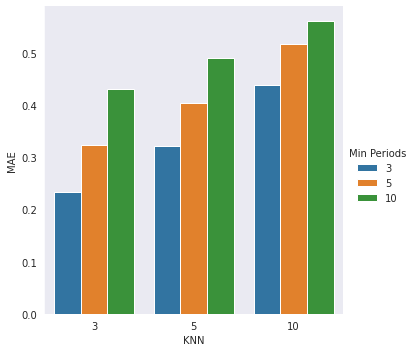

In [127]:
sns.catplot(data=scores, kind="bar", x="KNN", y="MAE", hue="Min Periods")

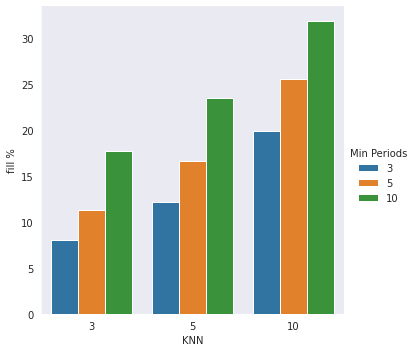

In [128]:
sns.catplot(data=scores, kind="bar", x="KNN", y="fill %", hue="Min Periods")

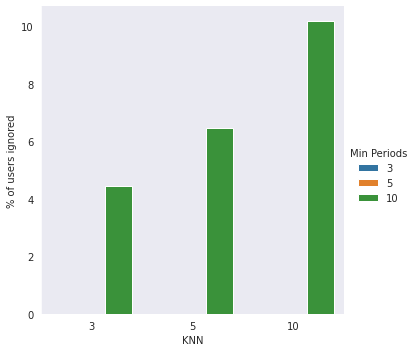

In [129]:
sns.catplot(data=scores, kind="bar", x="KNN", y="% of users ignored", hue="Min Periods")

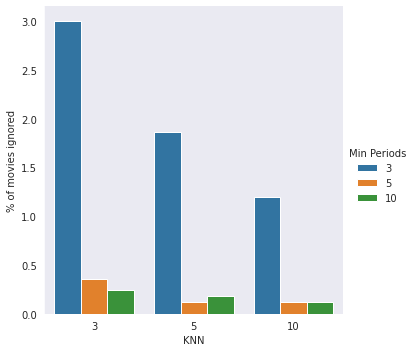

In [130]:
sns.catplot(data=scores, kind="bar", x="KNN", y="% of movies ignored", hue="Min Periods")

# 五次交叉驗證

In [121]:
movie_info_path = '/content/drive/MyDrive/作業代工/movielens/input/u.item'
u1_train_path = '/content/drive/MyDrive/作業代工/movielens/input/u1.base'
u1_test_path = '/content/drive/MyDrive/作業代工/movielens/input/u1.test'
u2_train_path = '/content/drive/MyDrive/作業代工/movielens/input/u2.base'
u2_test_path = '/content/drive/MyDrive/作業代工/movielens/input/u2.test'
u3_train_path = '/content/drive/MyDrive/作業代工/movielens/input/u3.base'
u3_test_path = '/content/drive/MyDrive/作業代工/movielens/input/u3.test'
u4_train_path = '/content/drive/MyDrive/作業代工/movielens/input/u4.base'
u4_test_path = '/content/drive/MyDrive/作業代工/movielens/input/u4.test'
u5_train_path = '/content/drive/MyDrive/作業代工/movielens/input/u5.base'
u5_test_path = '/content/drive/MyDrive/作業代工/movielens/input/u5.test'

# Evaluating Predictions¶ u1

In [135]:
user_ratings_train,user_ratings_test = load_data(u1_train_path,u1_test_path,movie_info_path)
pred_user, neighborhoods_user = recommendation_system_user_model(5, 10, user_ratings_train)
pred_user = pred_user.reindex(index=user_ratings_train.index)
# compare to the test set using MAE
error = mae(user_ratings_test, pred_user)
error

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


0.3987031195233088

In [136]:
pred_user

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
3,NaN,NaN,2.0,4.0,2.0,2.0,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,4.0,2.0,NaN,NaN,NaN,NaN
4,NaN,NaN,3.0,5.0,3.0,3.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,2.0,4.0,4.0,NaN,4.0,4.0,NaN,5.0,...,NaN,NaN,NaN,4.0,NaN,3.0,2.0,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,1.0,4.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN


下面我們可以看到用戶項目評分矩陣中計算值的百分比當然，計算值只是系統認為用戶將如何評價電影的預測。

In [137]:
df_fill_percentage(pred_user) - df_fill_percentage(user_ratings_train)

18.99

讓我們檢查運行推薦系統前後每個用戶的評分數。

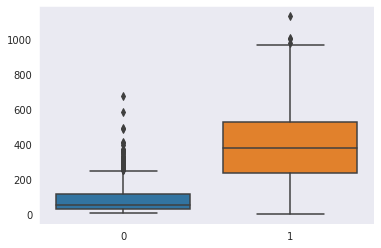

In [138]:
sns.boxplot(data=[user_ratings_train.count(axis=1), pred_user.count(axis=1)])

街區示例 下面我們看到 id 為 1 的用戶的鄰居，以及他們與用戶的相應距離

In [140]:
id1_neighbors = neighborhoods_user.loc[1]
id1_neighbors

neighborhood_ids       [227, 224, 142, 8, 135, 69, 329, 165, 37, 266]
distance            [0.059247096395113164, 0.0871290708247231, 0.1...
Name: 1, dtype: object

讓我們檢查一下他們的評分與用戶的評分情況 刪除至少有三個非 NaN 值的所有列（以便我們進行比較）

In [144]:
user_ratings.loc[[1]+id1_neighbors['neighborhood_ids']].dropna(axis='columns', thresh=3)

title,Air Force One (1997),Alien (1979),Aliens (1986),Apollo 13 (1995),Batman (1989),Bean (1997),Beavis and Butt-head Do America (1996),Big Night (1996),"Birdcage, The (1996)",Blade Runner (1982),...,"Terminator, The (1984)","Time to Kill, A (1996)",Titanic (1997),Trainspotting (1996),True Romance (1993),Twelve Monkeys (1995),Under Siege (1992),"Usual Suspects, The (1995)",White Squall (1996),"Wrong Trousers, The (1993)"
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,5.0,5.0,4.0,NaN,NaN,3.0,5.0,4.0,5.0,...,5.0,NaN,NaN,NaN,3.0,4.0,2.0,5.0,NaN,5.0
227,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,4.0,NaN,...,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN
224,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,5.0,NaN,1.0,NaN,NaN,NaN,3.0,NaN
142,NaN,NaN,5.0,4.0,NaN,2.0,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0
8,NaN,5.0,5.0,NaN,4.0,4.0,NaN,NaN,NaN,4.0,...,5.0,NaN,NaN,NaN,NaN,3.0,4.0,NaN,NaN,NaN
135,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,3.0,4.0,NaN,NaN
69,3.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,3.0,NaN,3.0,NaN,5.0,NaN,5.0,NaN,NaN
329,4.0,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN,NaN,...,NaN,3.0,4.0,NaN,NaN,3.0,NaN,4.0,3.0,4.0
165,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


我們可以觀察到 id 為 1 的用戶與他的鄰居有相似的品味。 例如，大多數人喜歡電影“外星人 (1986)”，並給它打了 5 或 4 星

針對特定用戶的推薦示例 我們可以在下面看到，對於特定用戶（例如 ID 為 208 的用戶），最高未知評分（測試數據中的評分）與系統預測的評分相比如何

In [145]:
user_ratings_test.loc[208].sort_values(ascending=False)[:20]

title
Graduate, The (1967)                         5.0
Being There (1979)                           5.0
When Harry Met Sally... (1989)               5.0
Butch Cassidy and the Sundance Kid (1969)    5.0
Sleepless in Seattle (1993)                  5.0
M*A*S*H (1970)                               5.0
Annie Hall (1977)                            4.0
Somewhere in Time (1980)                     4.0
Harold and Maude (1971)                      4.0
Groundhog Day (1993)                         4.0
Great Dictator, The (1940)                   4.0
Ghost (1990)                                 4.0
Duck Soup (1933)                             4.0
Cool Hand Luke (1967)                        4.0
Blues Brothers, The (1980)                   4.0
Young Frankenstein (1974)                    4.0
Back to the Future (1985)                    3.0
Four Weddings and a Funeral (1994)           3.0
Muriel's Wedding (1994)                      3.0
Pulp Fiction (1994)                          2.0
Name: 208, dty

In [146]:
pred_user[user_ratings_test.loc[208].sort_values(ascending=False)[:20].index].loc[208]

title
Graduate, The (1967)                         4.0
Being There (1979)                           4.0
When Harry Met Sally... (1989)               4.0
Butch Cassidy and the Sundance Kid (1969)    5.0
Sleepless in Seattle (1993)                  4.0
M*A*S*H (1970)                               4.0
Annie Hall (1977)                            3.0
Somewhere in Time (1980)                     5.0
Harold and Maude (1971)                      3.0
Groundhog Day (1993)                         4.0
Great Dictator, The (1940)                   NaN
Ghost (1990)                                 4.0
Duck Soup (1933)                             4.0
Cool Hand Luke (1967)                        4.0
Blues Brothers, The (1980)                   4.0
Young Frankenstein (1974)                    5.0
Back to the Future (1985)                    4.0
Four Weddings and a Funeral (1994)           3.0
Muriel's Wedding (1994)                      4.0
Pulp Fiction (1994)                          4.0
Name: 208, dty

# Evaluating Predictions¶ u2

In [151]:
user_ratings_train,user_ratings_test = load_data(u2_train_path,u2_test_path,movie_info_path)
pred_user, neighborhoods_user = recommendation_system_user_model(5, 10, user_ratings_train)
pred_user = pred_user.reindex(index=user_ratings_train.index)
# compare to the test set using MAE
error = mae(user_ratings_test, pred_user)
print(error)
display(user_ratings_test.loc[208].sort_values(ascending=False)[:20])
display(pred_user[user_ratings_test.loc[208].sort_values(ascending=False)[:20].index].loc[208])

0.3666483159001051


title
Bridges of Madison County, The (1995)          5.0
Sting, The (1973)                              5.0
Dances with Wolves (1990)                      4.0
Pretty Woman (1990)                            4.0
Rainmaker, The (1997)                          4.0
Big Green, The (1995)                          3.0
Manhattan (1979)                               3.0
'Til There Was You (1997)                      NaN
1-900 (1994)                                   NaN
101 Dalmatians (1996)                          NaN
12 Angry Men (1957)                            NaN
187 (1997)                                     NaN
2 Days in the Valley (1996)                    NaN
20,000 Leagues Under the Sea (1954)            NaN
2001: A Space Odyssey (1968)                   NaN
3 Ninjas: High Noon At Mega Mountain (1998)    NaN
39 Steps, The (1935)                           NaN
8 1/2 (1963)                                   NaN
8 Heads in a Duffel Bag (1997)                 NaN
8 Seconds (1994)         

title
Bridges of Madison County, The (1995)          NaN
Sting, The (1973)                              4.0
Dances with Wolves (1990)                      4.0
Pretty Woman (1990)                            4.0
Rainmaker, The (1997)                          4.0
Big Green, The (1995)                          NaN
Manhattan (1979)                               4.0
'Til There Was You (1997)                      4.0
1-900 (1994)                                   NaN
101 Dalmatians (1996)                          3.0
12 Angry Men (1957)                            NaN
187 (1997)                                     NaN
2 Days in the Valley (1996)                    NaN
20,000 Leagues Under the Sea (1954)            NaN
2001: A Space Odyssey (1968)                   4.0
3 Ninjas: High Noon At Mega Mountain (1998)    NaN
39 Steps, The (1935)                           NaN
8 1/2 (1963)                                   5.0
8 Heads in a Duffel Bag (1997)                 NaN
8 Seconds (1994)         

# Evaluating Predictions u3

In [152]:
user_ratings_train,user_ratings_test = load_data(u3_train_path,u3_test_path,movie_info_path)
pred_user, neighborhoods_user = recommendation_system_user_model(5, 10, user_ratings_train)
pred_user = pred_user.reindex(index=user_ratings_train.index)
# compare to the test set using MAE
error = mae(user_ratings_test, pred_user)
print(error)
display(user_ratings_test.loc[208].sort_values(ascending=False)[:20])
display(pred_user[user_ratings_test.loc[208].sort_values(ascending=False)[:20].index].loc[208])

0.3693269952464348


title
While You Were Sleeping (1995)                 4.0
Remains of the Day, The (1993)                 2.0
'Til There Was You (1997)                      NaN
1-900 (1994)                                   NaN
101 Dalmatians (1996)                          NaN
12 Angry Men (1957)                            NaN
187 (1997)                                     NaN
2 Days in the Valley (1996)                    NaN
20,000 Leagues Under the Sea (1954)            NaN
2001: A Space Odyssey (1968)                   NaN
3 Ninjas: High Noon At Mega Mountain (1998)    NaN
39 Steps, The (1935)                           NaN
8 1/2 (1963)                                   NaN
8 Heads in a Duffel Bag (1997)                 NaN
8 Seconds (1994)                               NaN
A Chef in Love (1996)                          NaN
Above the Rim (1994)                           NaN
Absolute Power (1997)                          NaN
Abyss, The (1989)                              NaN
Ace Ventura: Pet Detectiv

title
While You Were Sleeping (1995)                 NaN
Remains of the Day, The (1993)                 5.0
'Til There Was You (1997)                      NaN
1-900 (1994)                                   NaN
101 Dalmatians (1996)                          3.0
12 Angry Men (1957)                            NaN
187 (1997)                                     NaN
2 Days in the Valley (1996)                    NaN
20,000 Leagues Under the Sea (1954)            NaN
2001: A Space Odyssey (1968)                   4.0
3 Ninjas: High Noon At Mega Mountain (1998)    NaN
39 Steps, The (1935)                           NaN
8 1/2 (1963)                                   NaN
8 Heads in a Duffel Bag (1997)                 NaN
8 Seconds (1994)                               NaN
A Chef in Love (1996)                          NaN
Above the Rim (1994)                           NaN
Absolute Power (1997)                          NaN
Abyss, The (1989)                              4.0
Ace Ventura: Pet Detectiv

# Evaluating Predictions u4

In [153]:
user_ratings_train,user_ratings_test = load_data(u4_train_path,u4_test_path,movie_info_path)
pred_user, neighborhoods_user = recommendation_system_user_model(5, 10, user_ratings_train)
pred_user = pred_user.reindex(index=user_ratings_train.index)
# compare to the test set using MAE
error = mae(user_ratings_test, pred_user)
print(error)
display(user_ratings_test.loc[208].sort_values(ascending=False)[:20])
display(pred_user[user_ratings_test.loc[208].sort_values(ascending=False)[:20].index].loc[208])

0.38676176176176175


title
'Til There Was You (1997)                     NaN
1-900 (1994)                                  NaN
101 Dalmatians (1996)                         NaN
12 Angry Men (1957)                           NaN
187 (1997)                                    NaN
2 Days in the Valley (1996)                   NaN
20,000 Leagues Under the Sea (1954)           NaN
2001: A Space Odyssey (1968)                  NaN
3 Ninjas: High Noon At Mega Mountain (1998)   NaN
39 Steps, The (1935)                          NaN
8 1/2 (1963)                                  NaN
8 Heads in a Duffel Bag (1997)                NaN
8 Seconds (1994)                              NaN
A Chef in Love (1996)                         NaN
Above the Rim (1994)                          NaN
Absolute Power (1997)                         NaN
Abyss, The (1989)                             NaN
Ace Ventura: Pet Detective (1994)             NaN
Ace Ventura: When Nature Calls (1995)         NaN
Across the Sea of Time (1995)               

title
'Til There Was You (1997)                      NaN
1-900 (1994)                                   NaN
101 Dalmatians (1996)                          2.0
12 Angry Men (1957)                            4.0
187 (1997)                                     NaN
2 Days in the Valley (1996)                    NaN
20,000 Leagues Under the Sea (1954)            NaN
2001: A Space Odyssey (1968)                   3.0
3 Ninjas: High Noon At Mega Mountain (1998)    NaN
39 Steps, The (1935)                           4.0
8 1/2 (1963)                                   5.0
8 Heads in a Duffel Bag (1997)                 NaN
8 Seconds (1994)                               NaN
A Chef in Love (1996)                          NaN
Above the Rim (1994)                           NaN
Absolute Power (1997)                          NaN
Abyss, The (1989)                              3.0
Ace Ventura: Pet Detective (1994)              3.0
Ace Ventura: When Nature Calls (1995)          3.0
Across the Sea of Time (1

# Evaluating Predictions u5

In [154]:
user_ratings_train,user_ratings_test = load_data(u5_train_path,u5_test_path,movie_info_path)
pred_user, neighborhoods_user = recommendation_system_user_model(5, 10, user_ratings_train)
pred_user = pred_user.reindex(index=user_ratings_train.index)
# compare to the test set using MAE
error = mae(user_ratings_test, pred_user)
print(error)
display(user_ratings_test.loc[208].sort_values(ascending=False)[:20])
display(pred_user[user_ratings_test.loc[208].sort_values(ascending=False)[:20].index].loc[208])

0.4105015517068776


title
Mrs. Doubtfire (1993)                          4.0
French Kiss (1995)                             3.0
'Til There Was You (1997)                      NaN
1-900 (1994)                                   NaN
101 Dalmatians (1996)                          NaN
12 Angry Men (1957)                            NaN
187 (1997)                                     NaN
2 Days in the Valley (1996)                    NaN
20,000 Leagues Under the Sea (1954)            NaN
2001: A Space Odyssey (1968)                   NaN
3 Ninjas: High Noon At Mega Mountain (1998)    NaN
39 Steps, The (1935)                           NaN
8 1/2 (1963)                                   NaN
8 Heads in a Duffel Bag (1997)                 NaN
8 Seconds (1994)                               NaN
A Chef in Love (1996)                          NaN
Above the Rim (1994)                           NaN
Absolute Power (1997)                          NaN
Abyss, The (1989)                              NaN
Ace Ventura: Pet Detectiv

title
Mrs. Doubtfire (1993)                          3.0
French Kiss (1995)                             3.0
'Til There Was You (1997)                      NaN
1-900 (1994)                                   NaN
101 Dalmatians (1996)                          4.0
12 Angry Men (1957)                            4.0
187 (1997)                                     3.0
2 Days in the Valley (1996)                    NaN
20,000 Leagues Under the Sea (1954)            4.0
2001: A Space Odyssey (1968)                   4.0
3 Ninjas: High Noon At Mega Mountain (1998)    NaN
39 Steps, The (1935)                           4.0
8 1/2 (1963)                                   NaN
8 Heads in a Duffel Bag (1997)                 NaN
8 Seconds (1994)                               NaN
A Chef in Love (1996)                          NaN
Above the Rim (1994)                           NaN
Absolute Power (1997)                          NaN
Abyss, The (1989)                              4.0
Ace Ventura: Pet Detectiv

# 跑完u1到u5結果大約平均mae在0.39左右 test_anser跟pred_anser的rating 差異不大 然後資料上有許多電影是用戶沒有評分的
可以從下圖看出平分數高的電影很少

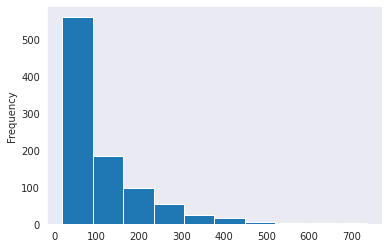

In [155]:
user_ratings.count(axis=1).plot(kind='hist')